In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
# from os import path1
# from sys import path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_excel('two-years-static.xlsx')
df = df.iloc[1:]
dic = list(df.columns)
col_dict = dict(zip(dic, ['week', 'total','upto17', '18-29', '30-64', '65+', 'hospital', 'indicator', 'epid', 'epid excess']))
df = df.rename(columns = col_dict, inplace = False)
df[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']] \
= df[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']].astype(int)
# df.set_index('week', inplace=True, drop=True)

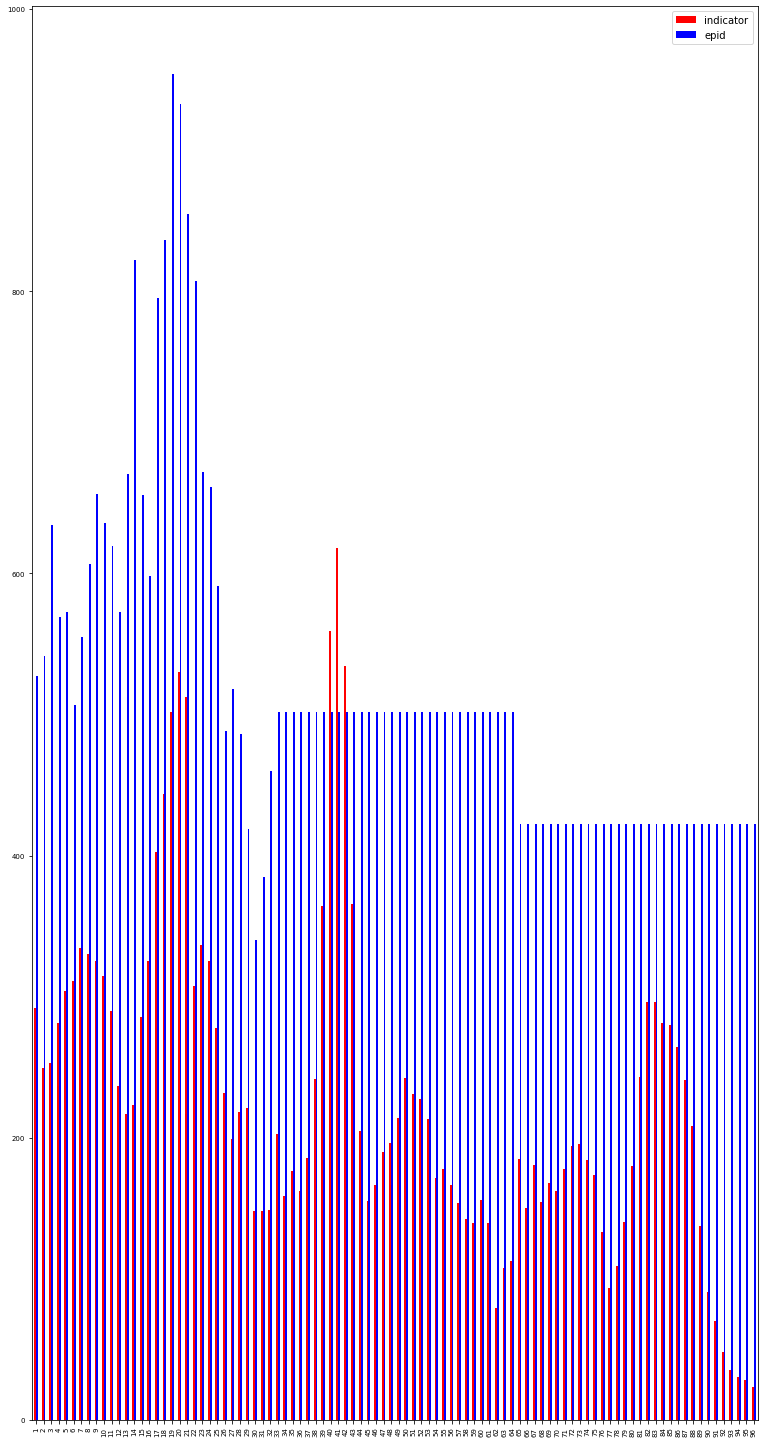

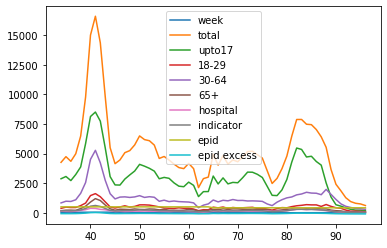

In [3]:
df.iloc[:, 7:9].plot(figsize=(13,26),kind='bar', color=['red', 'blue'], fontsize=7)
df2 = df.iloc[33:, :]
df2.plot()

<Figure size 432x288 with 0 Axes>

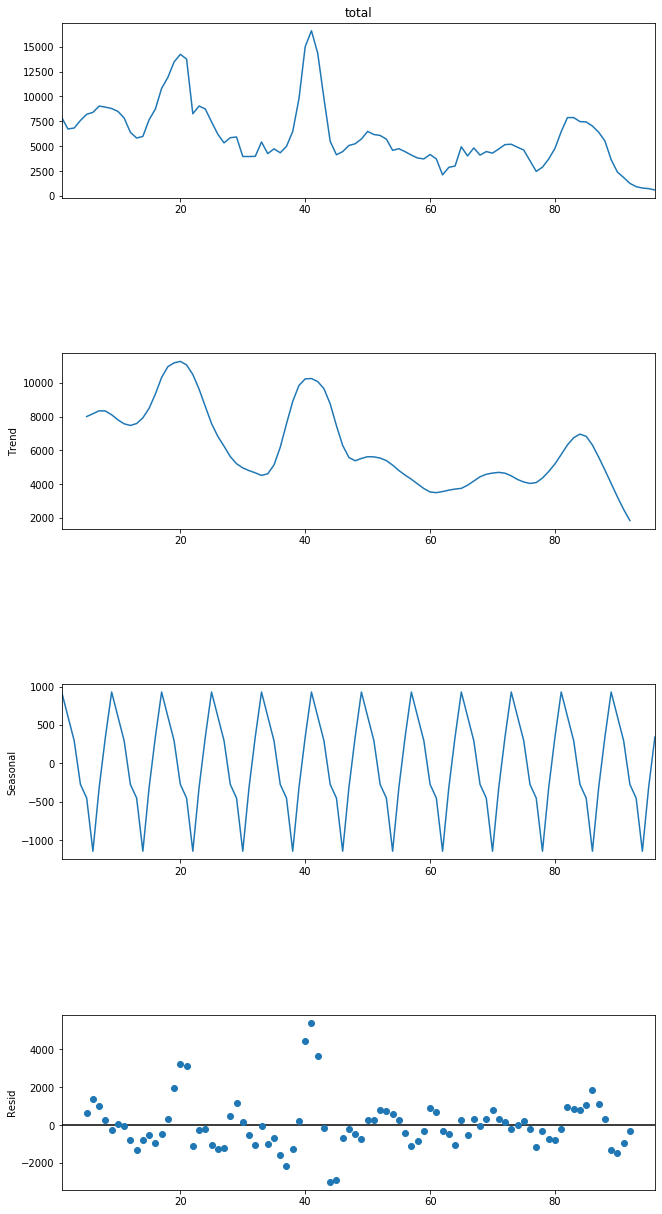

In [4]:
decomposition = seasonal_decompose(df.total, period=8)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 20)

In [5]:
trend = decomposition.trend
seasonal = decomposition.seasonal
print(trend, seasonal, sep='\n')

1         NaN
2         NaN
3         NaN
4         NaN
5     8011.75
       ...   
92    1846.75
93        NaN
94        NaN
95        NaN
96        NaN
Name: trend, Length: 96, dtype: float64
1      929.857955
2      611.329545
3      295.630682
4     -272.920455
5     -450.869318
         ...     
92    -272.920455
93    -450.869318
94   -1142.681818
95    -314.482955
96     344.136364
Name: seasonal, Length: 96, dtype: float64


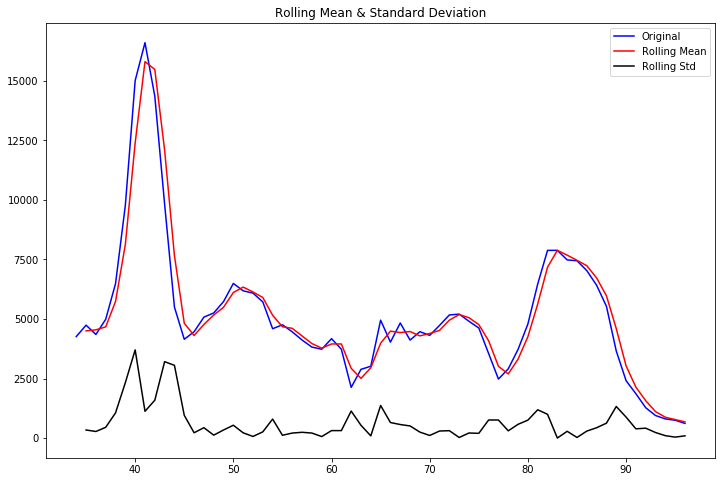

Results of Dickey-Fuller Test:
Test Statistic                 -1.771604
p-value                         0.394648
#Lags Used                      3.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [6]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=2).mean()
    rolstd = pd.Series(timeseries).rolling(window=2).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.total)

In [7]:
#first difference
df2['first_diff'] = df2 - df2.shift(1)
test_stationarity(df2.first_diff.dropna(inplace=False))

ValueError: Wrong number of items passed 10, placement implies 1

In [ ]:
#ACF and PACF charts
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df2.first_diff[5:], lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df2.first_diff.iloc[5:], lags=12, ax=ax2)

In [ ]:
import itertools
#set parameter range
p = range(1,3)
q = range(1,3)
d = range(0,2)
s = range(32,33)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df2.first_diff,
                          order=param,
                          seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
        except:
            continue
print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))

In [ ]:
mod = SARIMAX(df2.first_diff, trend='n', order=(2, 1, 2), seasonal_order=(2, 1, 2, 32))
results = mod.fit()
print(results.summary())

In [ ]:
df['predict_total'] = results.predict(start =40, end=50, dynamic= True)  
df[['total', 'predict_total']].plot(figsize=(12, 8))